In [1]:
import math
import sys
sys.path.insert(0,'..')
from citylearn.utilities import read_json
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from src.utilities import DataHandler, FileHandler

In [2]:
evaluation_data = DataHandler.get_concat_data('building_3-reward_tuning', 'evaluation')
evaluation_data['lower_exponent'] = evaluation_data['reward_function_kwargs'].map(lambda x: x['lower_exponent'])
evaluation_data['higher_exponent'] = evaluation_data['reward_function_kwargs'].map(lambda x: x['higher_exponent'])
evaluation_data = evaluation_data[
    (evaluation_data['environment']=='District')
    & (evaluation_data['higher_exponent'] <= evaluation_data['lower_exponent'] + 1.0)
].copy()
evaluation_data.head()

,environment,annual_normalized_unserved_energy_total,annual_peak_average,carbon_emissions_total,cost_total,daily_one_minus_load_factor_average,daily_peak_average,discomfort_delta_average,discomfort_delta_maximum,discomfort_delta_minimum,...,zero_net_energy,id,library,agent,rbc_name,central_agent,reward_function_name,reward_function_kwargs,lower_exponent,higher_exponent
1,District,0.0,0.946484,None,None,1.060432,0.948907,-1.140515,1.128633,-7.131971,...,0.918227,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
3,District,0.0,0.937540,None,None,1.086903,0.921870,-1.687219,1.723846,-7.118982,...,0.882568,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 2.0, 'higher_exponent': 2.8}",2.0,2.8
5,District,0.0,0.890195,None,None,1.095859,0.919881,-1.787845,0.847277,-7.858704,...,0.873760,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.2, 'higher_exponent': 2.2}",1.2,2.2
9,District,0.0,0.949572,None,None,1.082998,1.001516,-0.574953,0.632252,-5.442450,...,0.968843,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 1.4}",1.4,1.4
11,District,0.0,0.923092,None,None,1.083735,0.959247,-1.118061,1.285923,-6.860785,...,0.924651,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.0}",1.4,2.0


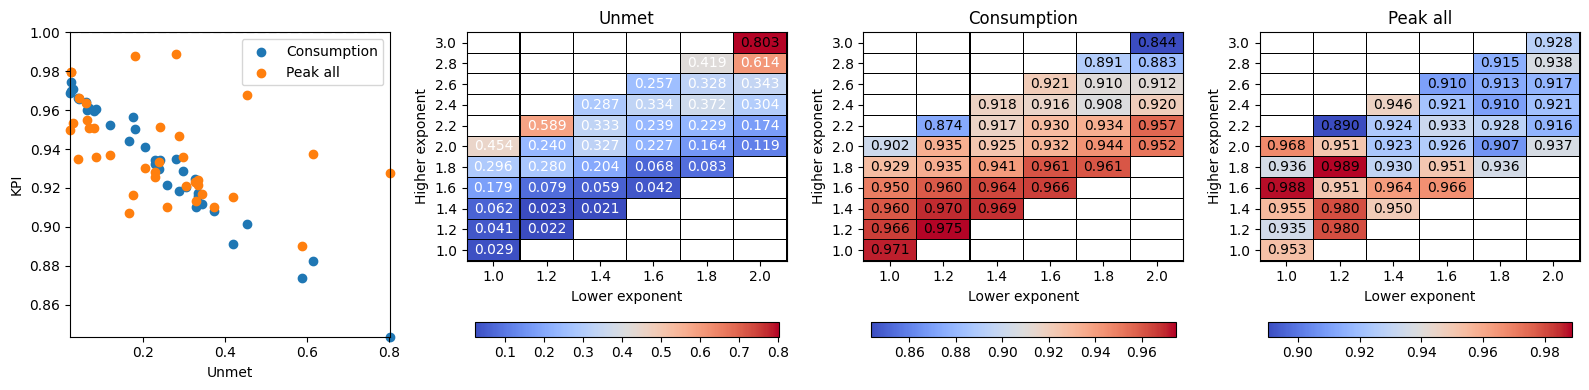

In [3]:
cmap = 'coolwarm'
columns = [
    'discomfort_proportion',
    'electricity_consumption_total',
    'annual_peak_average',
    # 'daily_one_minus_load_factor_average',
    # 'daily_peak_average',
    # 'ramping_average',
]
column_count_limit = 5
row_count = math.ceil((len(columns) + 1)/column_count_limit)
column_count = min(len(columns) + 1, column_count_limit)
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 4*row_count),)

# scatter plot
x = evaluation_data[columns[0]].tolist()

for c in columns[1:]:
    y = evaluation_data[c].tolist()
    fig.axes[0].scatter(x, y, clip_on=False, label=DataHandler.KPI_LABELS[c])

fig.axes[0].axhline(1.0, color='black', linestyle='--')
fig.axes[0].set_xlabel(DataHandler.KPI_LABELS[columns[0]])
fig.axes[0].set_ylabel('KPI')
fig.axes[0].margins(0)
fig.axes[0].legend()

for ax in fig.axes[len(columns) + 1:]:
    fig.delaxes(ax)

for i, (ax, c) in enumerate(zip(fig.axes[1:], columns)):
    vmin = evaluation_data[c].min()
    vmax = evaluation_data[c].max()
    vcenter = vmin + (vmax - vmin)/2.0
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    plot_data = evaluation_data.pivot(index='higher_exponent', columns='lower_exponent', values=c)
    x, y, z = plot_data.columns, plot_data.index, plot_data.values
    pcm = ax.pcolormesh(x, y, z, shading='nearest', cmap=cmap, norm=divnorm, edgecolors='black', linewidth=0.1)
    ax.set_xlabel('Lower exponent')
    ax.set_ylabel('Higher exponent')
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_title(DataHandler.KPI_LABELS[c])

    for (j, k), z in np.ndenumerate(plot_data):
        color = 'black' if 0.7 <= z <= 1.4 else 'white'
        ax.text(x[k], y[j], f'{z:0.3f}', ha='center', va='center', color=color)

    cb = fig.colorbar(pcm, ax=ax, orientation='horizontal', label=None, fraction=0.05, pad=0.2)

plt.tight_layout()
plt.show()

In [4]:
time_series_data = DataHandler.get_concat_data('building_3-reward_tuning', 'time_series')
time_series_data = time_series_data.merge(evaluation_data[['id', 'lower_exponent', 'higher_exponent']], on=['id'], how='right')
time_series_data.head()

,bldg_name,net_electricity_consumption,net_electricity_consumption_without_storage,net_electricity_consumption_without_storage_and_partial_load,net_electricity_consumption_without_storage_and_partial_load_and_pv,indoor_dry_bulb_temperature,indoor_dry_bulb_temperature_without_partial_load,indoor_dry_bulb_temperature_set_point,indoor_dry_bulb_temperature_set_point_without_control,occupant_count,...,environment,id,library,agent,rbc_name,central_agent,reward_function_name,reward_function_kwargs,lower_exponent,higher_exponent
0,481052,3.549666,3.549666,3.549666,3.549666,19.544359,19.544359,18.944445,18.944445,1.0,...,481052,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
1,481052,3.314902,3.314902,3.314902,3.314902,19.481224,19.481224,18.944445,18.944445,1.0,...,481052,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
2,481052,3.327730,3.327730,3.327730,3.327730,19.438789,19.438789,18.944445,18.944445,1.0,...,481052,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
3,481052,3.394101,3.394101,3.394101,3.394101,19.383667,19.383667,18.944445,18.944445,1.0,...,481052,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
4,481052,3.565225,3.565225,3.565225,3.565225,19.453754,19.453754,19.055555,19.055555,1.0,...,481052,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4


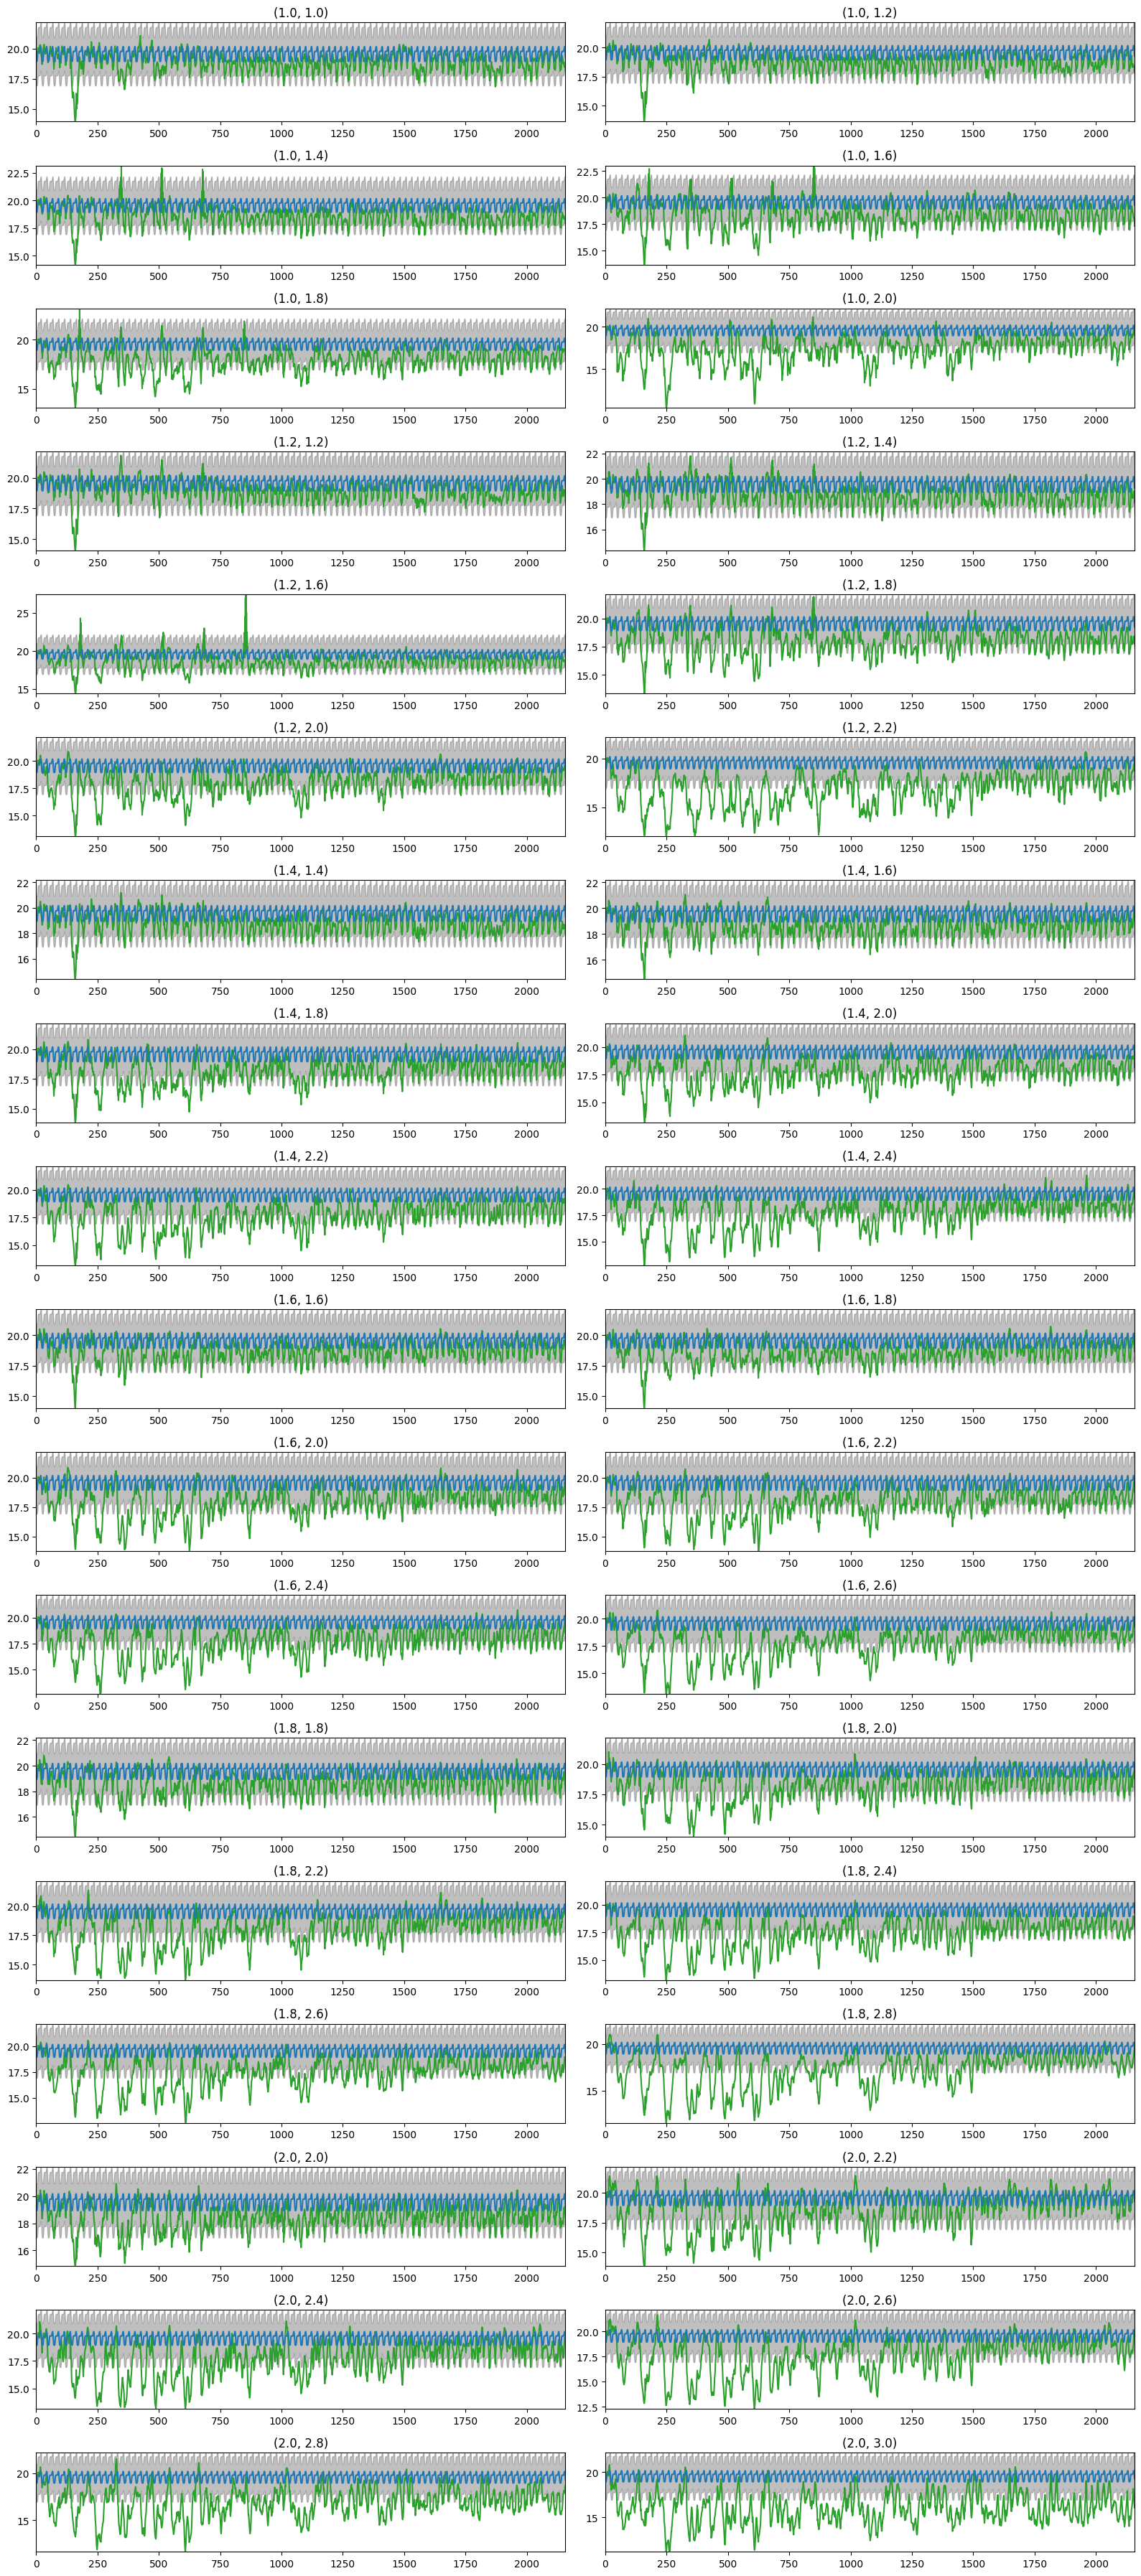

In [5]:
column_count_limit = 2
simulation_ids = time_series_data['id'].unique()
row_count = math.ceil(len(simulation_ids)/column_count_limit)
column_count = min(column_count_limit, len(simulation_ids))
fig, axs = plt.subplots(row_count, column_count, figsize=(8*column_count, 2.0*row_count))
start_ix, end_ix = 0, 2159

for ax in fig.axes[len(simulation_ids):]:
    fig.delaxes(ax)

for i, (ax, ((l, h), pdata)) in enumerate(zip(fig.axes, time_series_data.groupby(['lower_exponent', 'higher_exponent']))):
    pdata = pdata.iloc[start_ix:end_ix]
    x = pdata['time_step'].tolist()
    y = pdata['indoor_dry_bulb_temperature'].tolist()
    ax.plot(x, y, color='tab:green')
    y = pdata['indoor_dry_bulb_temperature_set_point'].tolist()
    ax.plot(x, y, color='tab:blue')
    y1 = pdata['indoor_dry_bulb_temperature_set_point'] - 2.0
    y2 = pdata['indoor_dry_bulb_temperature_set_point'] + 2.0
    ax.fill_between(x, y1.tolist(), y2.tolist(), color='grey', alpha=0.5)
    ax.set_title(f'({l}, {h})')
    ax.margins(0)

plt.tight_layout()
plt.show()

In [8]:
reward_data = DataHandler.get_concat_data('building_3-reward_tuning', 'rewards')
reward_data = reward_data.merge(evaluation_data[['id', 'lower_exponent', 'higher_exponent']], on=['id'], how='right')
reward_data.head()

,min,max,sum,mean,episode,environment,id,library,agent,rbc_name,central_agent,reward_function_name,reward_function_kwargs,lower_exponent,higher_exponent
0,-2098.616699,0.000000,-222665.343750,-103.133553,0,District,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
1,-122.310677,0.000000,-134432.796875,-62.266232,1,District,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
2,-120.172920,-0.046974,-122500.828125,-56.739616,2,District,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
3,-151.185150,0.000000,-108771.554688,-50.380524,3,District,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4
4,-78.560883,0.000000,-9868.613281,-4.570919,4,District,lod_2-stable_baselines3-sac-norbc-centralized-...,stable-baselines3,SAC,NoRBC,Centralized,ComfortReward,"{'lower_exponent': 1.4, 'higher_exponent': 2.4}",1.4,2.4


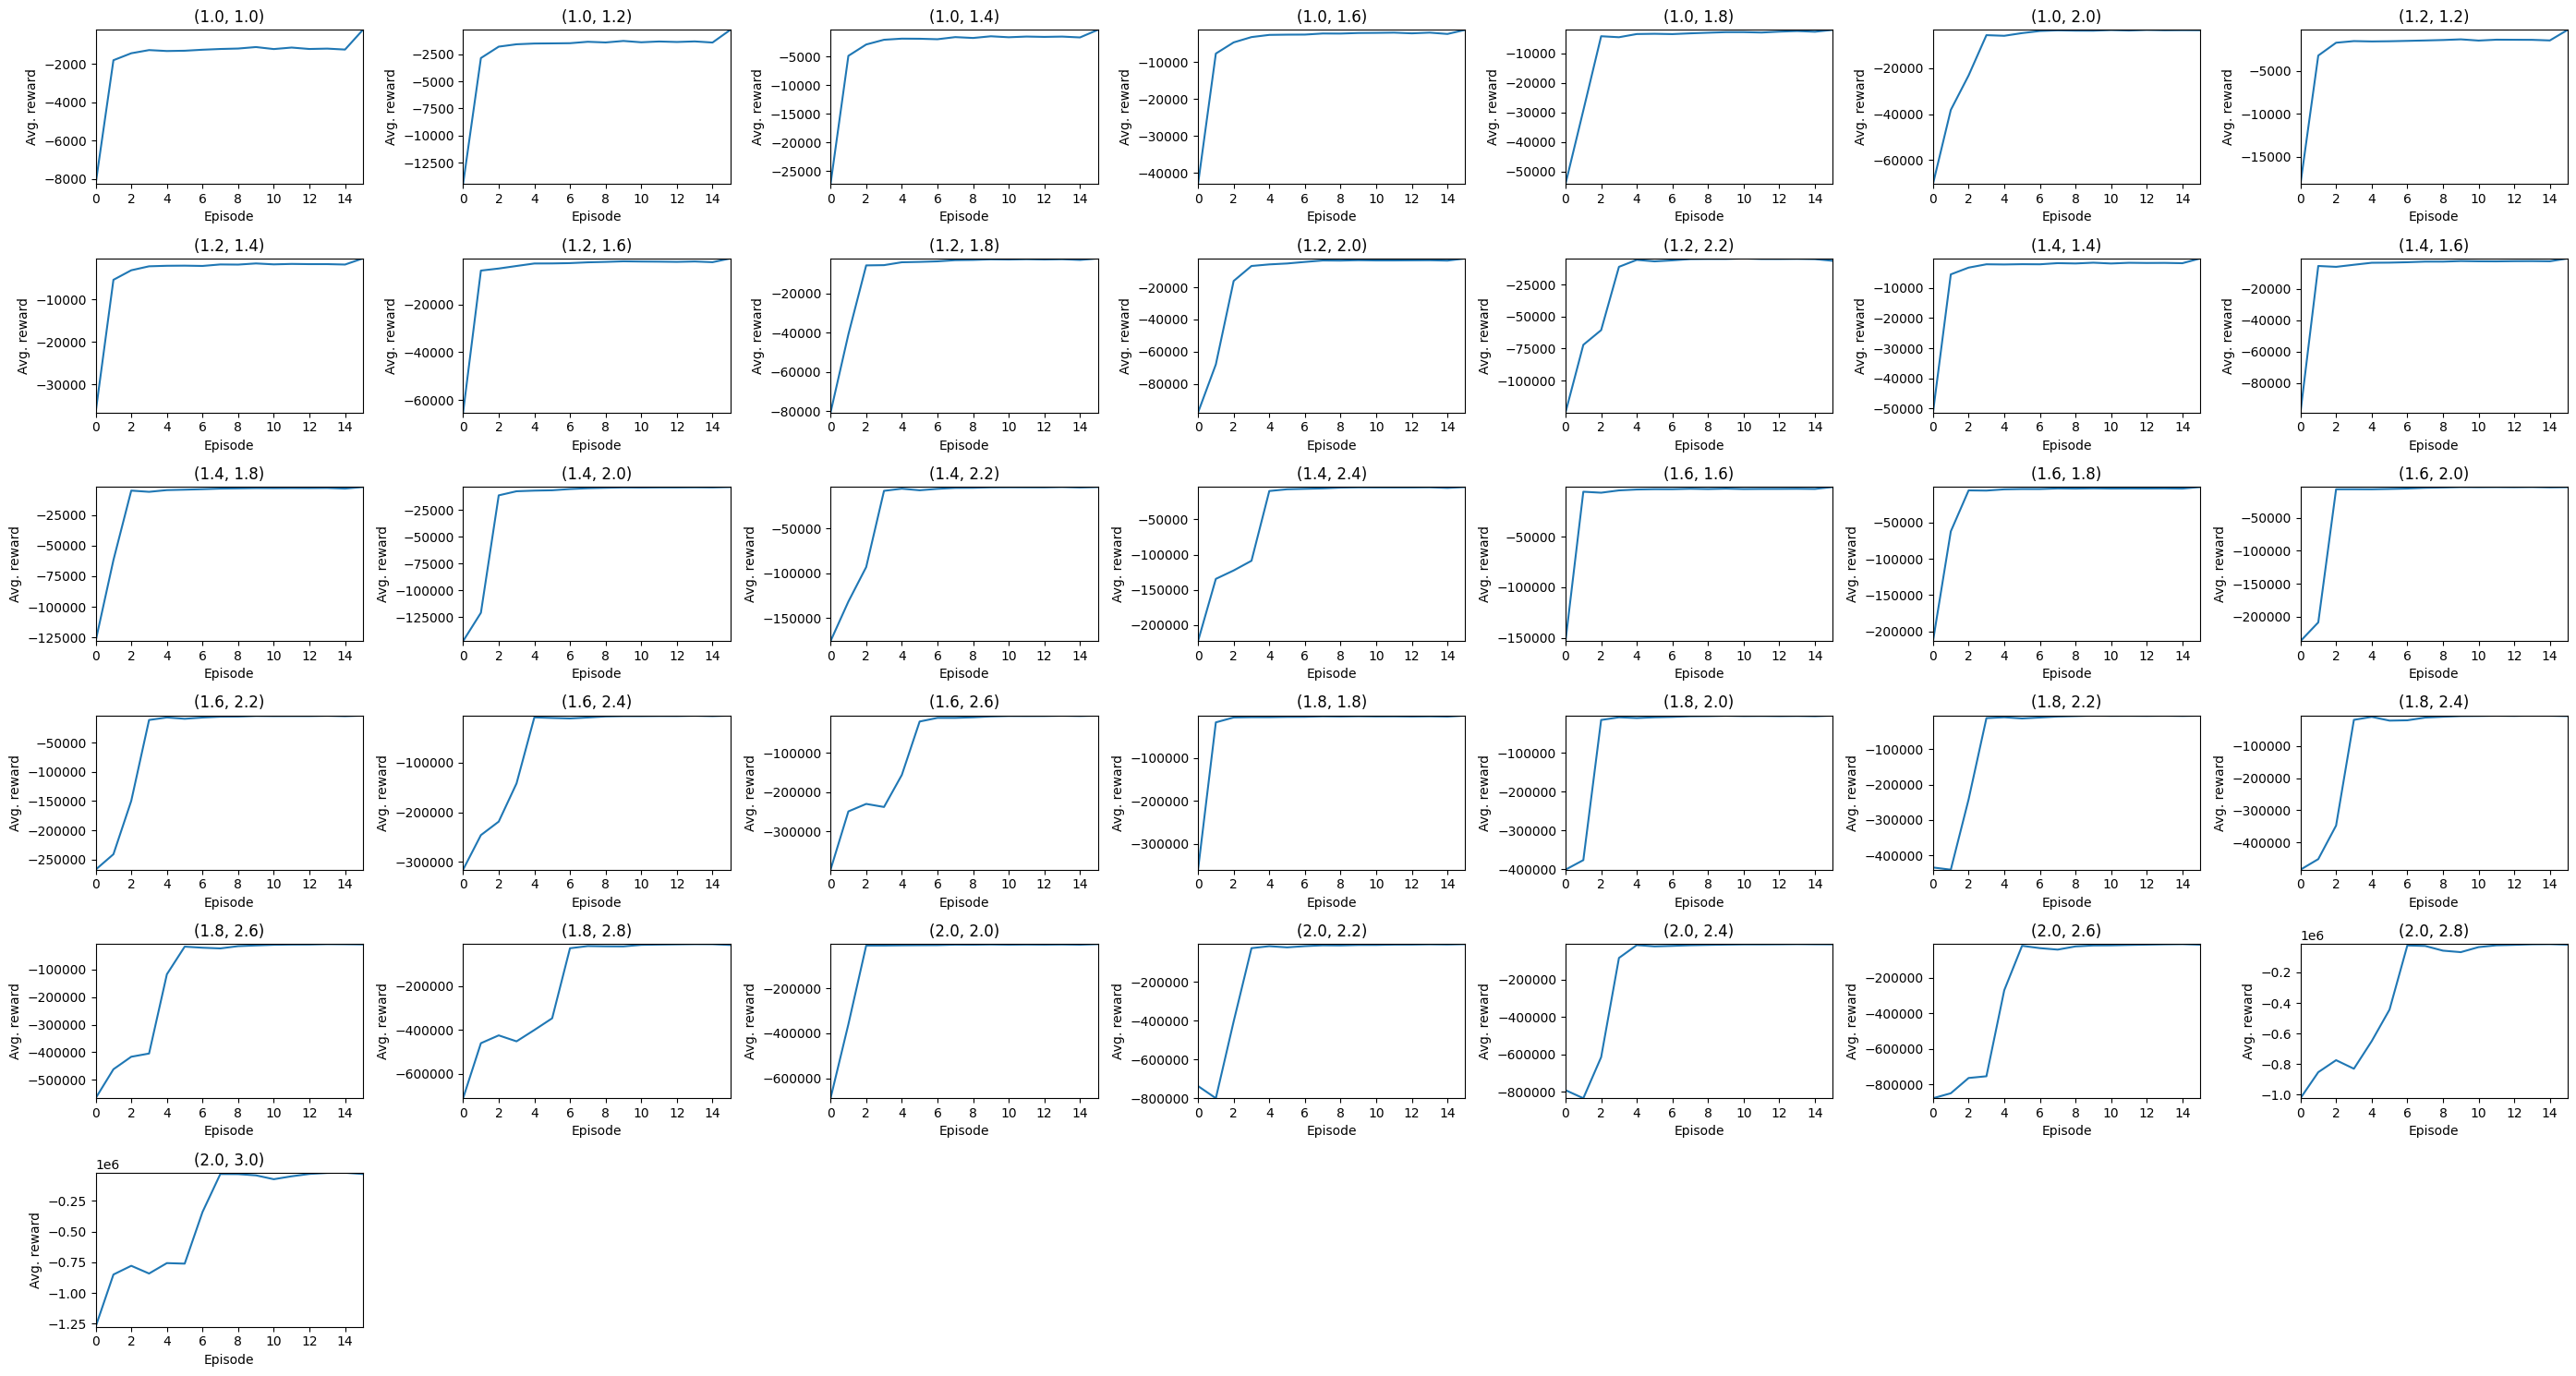

In [11]:
column_count_limit = 7
simulation_ids = reward_data['id'].unique()
row_count = math.ceil(len(simulation_ids)/column_count_limit)
column_count = min(len(simulation_ids), column_count_limit)
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 2.5*row_count))

for ax in fig.axes[len(simulation_ids):]:
    fig.delaxes(ax)

for i, (ax, ((l, h), rdata)) in enumerate(zip(fig.axes, reward_data.groupby(['lower_exponent', 'higher_exponent']))):
    x = rdata['episode'].tolist()
    y = rdata['sum'].tolist()
    ax.plot(x, y)
    ax.set_title(f'({l}, {h})')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Avg. reward')
    ax.set_xticks(range(0, max(x) + 2, 2))
    ax.margins(0)
    
plt.tight_layout()
plt.show()